In [1]:
import pandas as pd
import numpy as np
from glob2 import glob
from sklearn.decomposition import PCA
from scipy.linalg import norm 
import plotly_express as px
import seaborn as sns
sns.set(style = 'ticks')
%matplotlib inline
import os 
os.chdir('/Users/gracelyons/Desktop/MSDS/Capstone/')

In [2]:
token = pd.read_csv('output files/TOKEN.csv')

In [3]:
token.head()

,speaker_id,line_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id
0,201,1,0,0,"('Good', 'JJ')",JJ,Good,good,542
1,201,1,0,1,"('morning', 'NN')",NN,morning,morning,828
2,201,1,0,2,"('class', 'NN')",NN,class,class,231
3,201,1,1,0,"('I', 'PRP')",PRP,I,i,621
4,201,1,1,1,"(""'m"", 'VBP')",VBP,'m,m,764


In [4]:
vocab = pd.read_csv('output files/VOCAB.csv')

In [5]:
vocab.head()

,term_id,term_rank,term_str,n,num,stop,stemmer_porter,stemmer_snowball,stemmer_lancaster,pos_max,p,h,df,idf,tfidf_mean,tfidf_sum,tfidf_median,tfidf_max
0,1479,1,we,1745,0,1,we,we,we,PRP,0.035873,0.172224,88,0.004907,0.000175,0.015432,0.000174,0.000423
1,1545,2,you,1585,0,1,you,you,you,PRP,0.032584,0.160954,88,0.004907,0.000162,0.014214,0.000163,0.000280
2,1333,3,that,1553,0,1,that,that,that,DT,0.031926,0.158644,88,0.004907,0.000157,0.013844,0.000152,0.000300
3,1371,4,to,1524,0,1,to,to,to,TO,0.031330,0.156533,88,0.004907,0.000152,0.013417,0.000154,0.000289
4,1215,5,so,998,0,1,so,so,so,RB,0.020516,0.115037,89,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
lib = pd.read_csv('output files/LIB.csv')

In [7]:
lib.head()

,speaker_id,book_file
0,201,201_1.24.20_S_SC.txt
1,202,202_1.30.20_S_SC.txt
2,203,203_1.30.20_S_SC.txt
3,204,204_1.30.20_S_SC.txt
4,205,205_1.30.20_S_SC.txt


In [8]:
merged = token.merge(lib, how = 'left', on = 'speaker_id')

In [9]:
merged.head()

,speaker_id,line_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,book_file
0,201,1,0,0,"('Good', 'JJ')",JJ,Good,good,542,201_1.24.20_S_SC.txt
1,201,1,0,1,"('morning', 'NN')",NN,morning,morning,828,201_1.24.20_S_SC.txt
2,201,1,0,2,"('class', 'NN')",NN,class,class,231,201_1.24.20_S_SC.txt
3,201,1,1,0,"('I', 'PRP')",PRP,I,i,621,201_1.24.20_S_SC.txt
4,201,1,1,1,"(""'m"", 'VBP')",VBP,'m,m,764,201_1.24.20_S_SC.txt


In [10]:
# remove proper nouns, may also want to remove some other words 
token = merged[merged.pos != 'NNP']
short_strings = []
for term in token.term_str:
    if len(term) < 2:
        short_strings.append(term)
short_strings = short_strings[1:]
token = token[~token.term_str.isin(short_strings)]
vocab = vocab[~vocab.term_str.isin(short_strings)]

In [11]:
token.head()

,speaker_id,line_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,book_file
0,201,1,0,0,"('Good', 'JJ')",JJ,Good,good,542,201_1.24.20_S_SC.txt
1,201,1,0,1,"('morning', 'NN')",NN,morning,morning,828,201_1.24.20_S_SC.txt
2,201,1,0,2,"('class', 'NN')",NN,class,class,231,201_1.24.20_S_SC.txt
7,201,1,2,0,"('How', 'WRB')",WRB,How,how,613,201_1.24.20_S_SC.txt
8,201,1,2,1,"('are', 'VBP')",VBP,are,are,86,201_1.24.20_S_SC.txt


In [12]:
survey = pd.read_excel('survey_data.xlsx', usecols = ['studyid', 'assignment']).rename(columns = {'studyid': 'speaker_id', 'assignment': 'mindfulness'})

In [13]:
survey.head()

,speaker_id,mindfulness
0,201,1
1,202,0
2,203,1
3,204,0
4,205,1


In [14]:
token = token.merge(survey).drop(columns = ['book_file'])
token.head()

,speaker_id,line_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,mindfulness
0,201,1,0,0,"('Good', 'JJ')",JJ,Good,good,542,1
1,201,1,0,1,"('morning', 'NN')",NN,morning,morning,828,1
2,201,1,0,2,"('class', 'NN')",NN,class,class,231,1
3,201,1,2,0,"('How', 'WRB')",WRB,How,how,613,1
4,201,1,2,1,"('are', 'VBP')",VBP,are,are,86,1


### PCA

#### treatment

In [15]:
# start with the mindfulness = 1
token_1 = token[token.mindfulness == 1]
token_1.head()

,speaker_id,line_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,mindfulness
0,201,1,0,0,"('Good', 'JJ')",JJ,Good,good,542,1
1,201,1,0,1,"('morning', 'NN')",NN,morning,morning,828,1
2,201,1,0,2,"('class', 'NN')",NN,class,class,231,1
3,201,1,2,0,"('How', 'WRB')",WRB,How,how,613,1
4,201,1,2,1,"('are', 'VBP')",VBP,are,are,86,1


In [16]:
bag = ['speaker_id']
bow_1 = token_1.groupby(bag + ['term_id']).term_id.count().to_frame().rename(columns = {'term_id': 'n'})
bow_1['c'] = bow_1.n.astype('bool').astype('int')
bow_1.head()

n  c
speaker_id term_id      
201        8        6  1
           16       5  1
           21       1  1
           30       3  1
           43       4  1

In [17]:
dtcm_1 = bow_1['n'].unstack().fillna(0).astype('int')
dtcm_1.head()

term_id,5,7,8,10,11,13,14,15,16,17,...,1541,1542,1543,1544,1545,1546,1547,1548,1549,1553
speaker_id,,,,,,,,,,,,,,,,,,,,,
201,0,0,6,0,0,0,0,0,5,0,...,0,0,0,0,17,0,5,1,1,0
203,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,19,0,9,0,0,0
205,0,0,5,0,0,0,0,0,0,0,...,0,0,2,0,26,0,6,0,0,0
206,1,0,10,0,1,0,0,0,0,0,...,0,1,5,1,21,0,7,0,0,0
208,0,0,9,0,0,0,0,0,0,0,...,0,0,1,0,10,0,0,0,0,0


In [18]:
# this will keep all the words since we have less than 4000 words in our vocab table
top_vocab_1 = vocab['tfidf_sum'].nlargest(n=4000).rename_axis('term_id').reset_index()
top_vocab_1.head()

,term_id,tfidf_sum
0,647,0.234782
1,343,0.170105
2,82,0.130028
3,137,0.089034
4,55,0.079080


In [19]:
dtcm_1 = top_vocab_1.merge(dtcm_1.T, how = 'inner', on = 'term_id').set_index('term_id').drop(columns = ['tfidf_sum'])

In [20]:
dtcm_1.head()

,201,203,205,206,208,209,210,213,216,218,...,342,344,346,347,348,349,354,355,357,359
term_id,,,,,,,,,,,,,,,,,,,,,
647,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
137,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,1,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
107,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# create tfidf matrix
tf_1 = dtcm_1/dtcm_1.sum()
tf_1 = tf_1.T

df_1 = dtcm_1.T[dtcm_1.T > 0].count()

n_1 = dtcm_1.T.shape[0]

idf_1 = np.log10(n_1/df_1)

tfidf_1 = tf_1*idf_1

tfidf_1.head()

term_id,647,137,55,42,107,59,20,98,206,92,...,1187,1022,1162,1153,1369,991,993,1127,1006,1553
201,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
203,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000790,0.0,0.0
205,0.0,0.0,0.000000,0.0,0.006344,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.004255,0.000946,0.0,0.0
206,0.0,0.0,0.001284,0.0,0.000000,0.0,0.001106,0.0,0.0,0.0,...,0.001284,0.005321,0.00266,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
208,0.0,0.0,0.002931,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.002715,0.000000,0.0,0.0


In [22]:
tfidf_1 = tfidf_1.rename_axis('speaker_id')

In [23]:
# normalize doc vector lengths
tfidf_1 = tfidf_1.apply(lambda x: x /np.sqrt(np.square(x).sum()), 1)

In [24]:
# center word vectors
tfidf_1 = tfidf_1 - tfidf_1.mean()

In [25]:
# computer covariance matrix 
cov_1 = tfidf_1.T.dot(tfidf_1)/(tfidf_1.shape[0]-1)

In [26]:
cov_1.head()

term_id,647,137,55,42,107,59,20,98,206,92,...,1187,1022,1162,1153,1369,991,993,1127,1006,1553
term_id,,,,,,,,,,,,,,,,,,,,,
647,0.000256,-0.000009,-0.000031,-0.000006,-0.000014,-0.000008,0.000177,-0.000006,-0.000032,-0.000011,...,-0.000039,-0.000011,-0.000006,-0.000004,-0.000028,-0.000016,0.000296,0.000017,-0.000012,-0.000004
137,-0.000009,0.000518,-0.000044,-0.000009,-0.000020,-0.000012,0.000383,-0.000008,0.000232,-0.000016,...,-0.000055,-0.000016,-0.000008,-0.000006,-0.000039,-0.000023,-0.000080,-0.000088,-0.000017,-0.000006
55,-0.000031,-0.000044,0.001169,0.000091,-0.000071,-0.000041,-0.000164,-0.000030,-0.000079,-0.000056,...,-0.000099,0.000151,0.000076,-0.000021,-0.000076,-0.000083,0.000154,0.000834,-0.000062,-0.000021
42,-0.000006,-0.000009,0.000091,0.000246,-0.000014,-0.000008,-0.000040,-0.000006,-0.000031,-0.000011,...,-0.000038,-0.000011,-0.000005,-0.000004,0.000105,-0.000016,0.000283,-0.000061,-0.000012,-0.000004
107,-0.000014,-0.000020,-0.000071,-0.000014,0.001375,-0.000019,-0.000095,-0.000014,-0.000074,-0.000026,...,-0.000089,-0.000026,-0.000013,-0.000010,-0.000064,-0.000038,0.000814,0.000067,-0.000028,-0.000010


In [27]:
cov_1.iloc[:5, :10].style.background_gradient()

term_id,647,137,55,42,107,59,20,98,206,92
term_id,,,,,,,,,,
647,0.000256,-0.000009,-0.000031,-0.000006,-0.000014,-0.000008,0.000177,-0.000006,-0.000032,-0.000011
137,-0.000009,0.000518,-0.000044,-0.000009,-0.000020,-0.000012,0.000383,-0.000008,0.000232,-0.000016
55,-0.000031,-0.000044,0.001169,0.000091,-0.000071,-0.000041,-0.000164,-0.000030,-0.000079,-0.000056
42,-0.000006,-0.000009,0.000091,0.000246,-0.000014,-0.000008,-0.000040,-0.000006,-0.000031,-0.000011
107,-0.000014,-0.000020,-0.000071,-0.000014,0.001375,-0.000019,-0.000095,-0.000014,-0.000074,-0.000026


In [28]:
# decompose the matrix
from scipy.linalg import eigh
eig_vals_1, eig_vecs_1 = eigh(cov_1)

In [29]:
# convert eigen data to dataframe
term_idx_1 = cov_1.index
eig_vec_1 = pd.DataFrame(eig_vecs_1, index = term_idx_1, columns = term_idx_1)

In [30]:
eig_val_1 = pd.DataFrame(eig_vals_1, index = term_idx_1, columns = ['eig_val'])
eig_val_1.index.name = 'term_id'

In [31]:
eig_vec_1.head()

term_id,647,137,55,42,107,59,20,98,206,92,...,1187,1022,1162,1153,1369,991,993,1127,1006,1553
term_id,,,,,,,,,,,,,,,,,,,,,
647,0.000000,0.000000,0.000000,-0.060321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.024634,-0.015329,0.018297,0.008031,-0.000971,0.011074,-0.005621,0.021695,-0.006373,0.023348
137,0.067154,-0.057410,-0.194254,-0.092520,-0.071127,-0.105032,-0.124997,-0.024602,0.106839,-0.101361,...,-0.011400,-0.006884,-0.029873,-0.019250,-0.000520,-0.014107,-0.005293,0.004807,-0.026922,-0.009094
55,-0.078069,0.024343,0.073100,-0.037201,0.049784,0.139258,-0.144772,-0.032197,-0.057220,0.007425,...,0.034529,0.032801,0.022123,0.009430,0.056936,0.004929,-0.034562,-0.000817,-0.015466,-0.033695
42,0.152517,-0.069777,0.029677,-0.091850,0.125650,-0.005388,-0.057106,-0.036259,0.057695,-0.018080,...,0.012540,-0.014003,-0.009345,0.011627,0.024258,0.017253,-0.008858,-0.007460,-0.015619,-0.017065
107,-0.114470,0.035815,0.009997,-0.119676,0.038689,-0.033872,-0.256561,0.053718,-0.120199,0.073558,...,-0.046066,0.027337,0.012530,0.001469,-0.011690,0.036009,0.007322,0.017388,0.000362,0.071028


In [32]:
eig_vec_1.iloc[:5, :10].style.background_gradient()

term_id,647,137,55,42,107,59,20,98,206,92
term_id,,,,,,,,,,
647,0.000000,0.000000,0.000000,-0.060321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
137,0.067154,-0.057410,-0.194254,-0.092520,-0.071127,-0.105032,-0.124997,-0.024602,0.106839,-0.101361
55,-0.078069,0.024343,0.073100,-0.037201,0.049784,0.139258,-0.144772,-0.032197,-0.057220,0.007425
42,0.152517,-0.069777,0.029677,-0.091850,0.125650,-0.005388,-0.057106,-0.036259,0.057695,-0.018080
107,-0.114470,0.035815,0.009997,-0.119676,0.038689,-0.033872,-0.256561,0.053718,-0.120199,0.073558


In [33]:
eig_val_1.iloc[:5]

,eig_val
term_id,
647,-1.774531e-17
137,-1.103856e-17
55,-9.615745e-18
42,-3.017742e-18
107,-1.901316e-18


In [34]:
# select principal components
# combine eigenvalues and eigenvectors
eig_pairs_1 = eig_val_1.join(eig_vec_1.T)

In [35]:
eig_pairs_1.head()

,eig_val,647,137,55,42,107,59,20,98,206,...,1187,1022,1162,1153,1369,991,993,1127,1006,1553
term_id,,,,,,,,,,,,,,,,,,,,,
647,-1.774531e-17,0.000000,0.067154,-0.078069,0.152517,-0.114470,-0.012711,0.042470,-0.057673,-0.061788,...,0.020783,-0.014679,-0.007340,0.002354,-0.008640,-0.008031,0.029984,0.009979,-0.006607,0.003202
137,-1.103856e-17,0.000000,-0.057410,0.024343,-0.069777,0.035815,0.058039,0.037674,0.072908,0.026053,...,0.025270,0.036162,0.018081,0.001391,0.029607,-0.022330,-0.055612,-0.054821,-0.013993,-0.002015
55,-9.615745e-18,0.000000,-0.194254,0.073100,0.029677,0.009997,0.134895,-0.056316,0.062587,-0.007479,...,-0.023058,0.015852,0.007926,0.002006,-0.011290,0.002939,-0.009353,0.012533,0.005064,0.003764
42,-3.017742e-18,-0.060321,-0.092520,-0.037201,-0.091850,-0.119676,-0.051984,-0.149939,0.003888,-0.091364,...,-0.002604,0.005797,0.002899,0.002149,-0.024192,0.009778,-0.009680,-0.000129,-0.014349,0.000453
107,-1.901316e-18,0.000000,-0.071127,0.049784,0.125650,0.038689,0.028993,0.227395,0.107216,-0.121975,...,0.096673,-0.018677,-0.009338,0.002272,-0.017797,0.008003,0.034119,-0.015728,0.001482,0.000630


In [36]:
# compute and show explained variance 
eig_pairs_1['exp_var'] = np.round((eig_pairs_1.eig_val / eig_pairs_1.eig_val.sum()) * 100, 2)

<AxesSubplot:xlabel='term_id'>

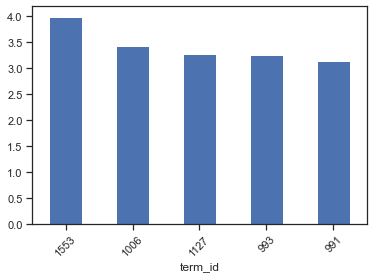

In [37]:
eig_pairs_1.exp_var.sort_values(ascending = False).head().plot.bar(rot = 45)

In [38]:
# pick top 10 components
comps_1 = eig_pairs_1.sort_values('exp_var', ascending = False).head(10).reset_index()
comps_1.index.name = 'comp_id'
comps_1.index = ["PC{}".format(i) for i in comps_1.index.tolist()]

In [39]:
comps_1

,term_id,eig_val,647,137,55,42,107,59,20,98,...,1022,1162,1153,1369,991,993,1127,1006,1553,exp_var
PC0,1553,0.035460,0.023348,-0.009094,-0.033695,-0.017065,0.071028,0.010254,-0.019776,0.000333,...,-0.024588,-0.012294,-0.001027,-0.037208,0.007363,0.026724,-0.045613,-0.005467,-0.001027,3.99
PC1,1006,0.030437,-0.006373,-0.026922,-0.015466,-0.015619,0.000362,-0.023594,-0.049566,0.018275,...,0.019013,0.009506,-0.002717,0.025562,0.000076,-0.106038,0.010540,-0.002086,-0.002717,3.43
PC2,1127,0.029060,0.021695,0.004807,-0.000817,-0.007460,0.017388,-0.010139,0.020772,0.015022,...,-0.035709,-0.017855,-0.001561,-0.034198,-0.030453,0.005239,-0.030328,0.009518,-0.001561,3.27
PC3,993,0.028976,-0.005621,-0.005293,-0.034562,-0.008858,0.007322,0.022862,-0.024855,0.002178,...,-0.029158,-0.014579,-0.012714,0.029853,-0.030952,0.023149,-0.034232,0.004684,-0.012714,3.26
PC4,991,0.027772,0.011074,-0.014107,0.004929,0.017253,0.036009,0.028268,-0.018207,0.006628,...,0.012226,0.006113,-0.004807,0.018430,0.026377,0.143214,-0.026547,-0.014403,-0.004807,3.13
PC5,1369,0.027227,-0.000971,-0.000520,0.056936,0.024258,-0.011690,-0.001925,-0.006660,-0.013647,...,-0.023207,-0.011603,-0.025025,-0.005516,-0.006602,0.032613,0.065195,-0.002532,-0.025025,3.07
PC6,1153,0.026737,0.008031,-0.019250,0.009430,0.011627,0.001469,-0.055363,-0.039049,0.000258,...,-0.020255,-0.010127,0.018390,0.024438,0.009784,-0.012118,0.055511,-0.052900,0.018390,3.01
PC7,1162,0.025960,0.018297,-0.029873,0.022123,-0.009345,0.012530,0.030133,-0.034258,0.000089,...,-0.040208,-0.020104,0.000309,0.014703,-0.000475,0.012777,0.135491,0.012009,0.000309,2.92
PC8,1022,0.025713,-0.015329,-0.006884,0.032801,-0.014003,0.027337,-0.014323,-0.021093,0.022594,...,-0.017584,-0.008792,0.001268,-0.037123,-0.014584,-0.004780,0.132203,-0.028448,0.001268,2.90
PC9,1187,0.025270,-0.024634,-0.011400,0.034529,0.012540,-0.046066,0.013303,-0.056360,-0.002677,...,-0.022326,-0.011163,0.006577,0.032517,-0.025930,-0.068490,0.015240,-0.041046,0.006577,2.85


In [40]:
# inspect terms 
top_terms = [int(x) for x in eig_pairs_1.sort_values('exp_var', ascending = False).head(10).index]
vocab[vocab.term_id.isin(top_terms)]

,term_id,term_rank,term_str,n,num,stop,stemmer_porter,stemmer_snowball,stemmer_lancaster,pos_max,p,h,df,idf,tfidf_mean,tfidf_sum,tfidf_median,tfidf_max
155,1127,156,rules,60,0,0,rule,rule,rul,NNS,0.001233,0.011919,29,0.486992,0.001866,0.054121,0.001197,0.005921
227,993,228,prepared,34,0,0,prepar,prepar,prep,VBN,0.000699,0.007327,19,0.670636,0.002099,0.039886,0.002032,0.003536
308,1187,309,showing,20,0,0,show,show,show,VBG,0.000411,0.004625,13,0.835447,0.002347,0.030515,0.002063,0.005313
329,1369,330,tired,17,0,0,tire,tire,tir,VBN,0.000349,0.004013,15,0.773299,0.001611,0.024167,0.001451,0.003009
440,991,441,practice,9,0,0,practic,practic,pract,NN,0.000185,0.002294,8,1.046300,0.001997,0.015973,0.001867,0.003270
511,1162,512,seem,6,0,0,seem,seem,seem,VB,0.000123,0.001602,6,1.171239,0.002131,0.012784,0.002052,0.002802
828,1006,829,proceed,2,0,0,proceed,proceed,process,VB,0.000041,0.000599,1,1.949390,0.005430,0.005430,0.005430,0.005430
854,1022,855,punctuality,2,0,0,punctual,punctual,punct,NN,0.000041,0.000599,1,1.949390,0.005634,0.005634,0.005634,0.005634
991,1153,992,scratch,1,0,0,scratch,scratch,scratch,VB,0.000021,0.000320,1,1.949390,0.002302,0.002302,0.002302,0.002302
1553,1553,1554,zone,1,0,0,zone,zone,zon,NN,0.000021,0.000320,1,1.949390,0.002302,0.002302,0.002302,0.002302


In [41]:
# show loadings 
loadings_1 = comps_1[term_idx_1].T
loadings_1.index.name = 'term_id'
loadings_1.head().style.background_gradient()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_id,,,,,,,,,,
647,0.023348,-0.006373,0.021695,-0.005621,0.011074,-0.000971,0.008031,0.018297,-0.015329,-0.024634
137,-0.009094,-0.026922,0.004807,-0.005293,-0.014107,-0.000520,-0.019250,-0.029873,-0.006884,-0.011400
55,-0.033695,-0.015466,-0.000817,-0.034562,0.004929,0.056936,0.009430,0.022123,0.032801,0.034529
42,-0.017065,-0.015619,-0.007460,-0.008858,0.017253,0.024258,0.011627,-0.009345,-0.014003,0.012540
107,0.071028,0.000362,0.017388,0.007322,0.036009,-0.011690,0.001469,0.012530,0.027337,-0.046066


In [42]:
loadings_1['term_str'] = loadings_1.apply(lambda x: vocab.loc[int(x.name)].term_str, 1)

In [43]:
l0_pos_1 = loadings_1.sort_values('PC0', ascending = True).head(10).term_str.str.cat(sep = ' ')
l0_neg_1 = loadings_1.sort_values('PC0', ascending = False).head(10).term_str.str.cat(sep = ' ')
l1_pos_1 = loadings_1.sort_values('PC1', ascending = True).head(10).term_str.str.cat(sep = ' ')
l1_neg_1 = loadings_1.sort_values('PC1', ascending = False).head(10).term_str.str.cat(sep = ' ')

In [44]:
print('Speakers PC0+', l0_pos_1)
print('Speakers PC0-', l0_neg_1)
print('Speakers PC1+', l1_pos_1)
print('Speakers PC1-', l1_neg_1)

Speakers PC0+ cross readings here keeping easier lockers someone classroom back direction
Speakers PC0- came only break ha there jenna plot scale create restful
Speakers PC1+ wherever throughout rhythm walls conversation update move lockers overbreak material
Speakers PC1- rings rocket curious aside can yourselves un wiggle because change


In [45]:
# project speakers onto new subspace
dcm_1 = tfidf_1.dot(comps_1[term_idx_1].T).reset_index()
dcm_1

,speaker_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,201,0.164808,0.155225,-0.272979,0.346848,-0.008351,0.018743,0.261826,-0.191669,-0.302140,-0.016303
1,203,0.148903,-0.364942,-0.071471,0.278918,-0.018062,0.038942,-0.190986,0.023246,0.245005,0.211630
2,205,0.434967,0.001904,0.087267,0.036641,0.172706,-0.054970,0.006782,0.056174,0.121393,-0.201036
3,206,-0.192903,0.128034,-0.229596,-0.186930,0.075125,-0.139795,-0.119819,-0.230944,-0.100037,-0.124823
4,208,-0.206828,-0.110209,0.079672,-0.055383,0.174063,-0.054324,-0.035295,-0.087712,0.070330,-0.107173
5,209,-0.090724,-0.230549,0.039300,-0.043151,-0.110225,-0.003986,-0.144809,-0.218190,-0.049798,-0.081049
6,210,-0.038511,-0.012615,0.054947,0.026960,-0.079460,-0.013696,-0.280968,0.061928,-0.145308,-0.206043
7,213,0.381750,0.111329,-0.047354,-0.083957,0.068672,-0.079181,0.180307,-0.156986,0.017237,-0.093192
8,216,0.331127,-0.077574,0.252152,-0.065140,0.122997,-0.010572,0.085880,0.189971,-0.157640,-0.248965
9,218,0.368156,-0.058332,-0.192063,-0.122576,0.205699,-0.027114,0.051712,0.101844,-0.004191,-0.004353


#### control

In [87]:
# start with the mindfulness = 0
token_0 = token[token.mindfulness == 0]
token_0.head()

,speaker_id,line_num,sent_num,token_num,pos_tuple,pos,token_str,term_str,term_id,mindfulness
469,202,3,1,0,"('Good', 'JJ')",JJ,Good,good,542,0
470,202,3,1,1,"('morning', 'NN')",NN,morning,morning,828,0
471,202,3,1,3,"('class', 'NN')",NN,class,class,231,0
472,202,3,2,0,"('How', 'WRB')",WRB,How,how,613,0
473,202,3,2,1,"('are', 'VBP')",VBP,are,are,86,0


In [88]:
bag = ['speaker_id']
bow_0 = token_0.groupby(bag + ['term_id']).term_id.count().to_frame().rename(columns = {'term_id': 'n'})
bow_0['c'] = bow_0.n.astype('bool').astype('int')
bow_0.head()

n  c
speaker_id term_id      
202        8        2  1
           16       4  1
           21       1  1
           28       1  1
           30       1  1

In [89]:
dtcm_0 = bow_0['n'].unstack().fillna(0).astype('int')
dtcm_0.head()

term_id,4,6,7,8,9,10,12,14,16,17,...,1540,1542,1543,1544,1545,1547,1548,1549,1550,1551
speaker_id,,,,,,,,,,,,,,,,,,,,,
202,0,0,0,2,0,0,0,0,4,0,...,0,0,1,0,15,4,0,0,0,0
204,0,0,0,6,0,0,0,0,0,0,...,0,0,0,0,29,9,0,0,0,0
207,0,0,0,13,0,0,0,1,0,0,...,0,0,5,0,17,4,0,0,0,0
211,0,0,2,4,0,0,1,0,0,0,...,0,0,1,0,9,5,0,0,0,0
212,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,11,1,0,0,0,0


In [90]:
# this will keep all the words since we have less than 4000 words in our vocab table
top_vocab_0 = vocab['tfidf_sum'].nlargest(n=4000).rename_axis('term_id').reset_index()
top_vocab_0.head()

,term_id,tfidf_sum
0,647,0.234782
1,343,0.170105
2,82,0.130028
3,137,0.089034
4,55,0.079080


In [91]:
dtcm_0 = top_vocab_0.merge(dtcm_0.T, how = 'inner', on = 'term_id').set_index('term_id').drop(columns = ['tfidf_sum'])

In [92]:
dtcm_0.head()

,202,204,207,211,212,214,215,217,219,220,...,340,343,345,350,351,352,353,356,358,360
term_id,,,,,,,,,,,,,,,,,,,,,
343,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
82,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,0,0,1,0,0,0,0,...,0,0,3,4,0,0,0,0,0,2
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# create tfidf matrix
tf_0 = dtcm_0/dtcm_0.sum()
tf_0 = tf_0.T

df_0 = dtcm_0.T[dtcm_0.T > 0].count()

n_0 = dtcm_0.T.shape[0]

idf_0 = np.log(n_0/df_0)

tfidf_0 = tf_0*idf_0

tfidf_0.head()

term_id,343,82,55,107,59,20,110,206,87,78,...,1472,1187,1300,1325,1162,1369,991,993,1127,4
202,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003345,0.0,0.0,0.000000,0.000000,0.0,0.007048,0.007360,0.0
204,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.003778,0.0,0.003090,0.000000,0.0
207,0.005551,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
211,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003378,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0
212,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.003632,0.000000,0.0,0.000000,0.001834,0.0


In [94]:
tfidf_0 = tfidf_0.rename_axis('speaker_id')
tfidf_0 = tfidf_0.drop(1215, axis = 1)

In [95]:
# normalize doc vector lengths
tfidf_0 = tfidf_0.apply(lambda x: x /np.sqrt(np.square(x).sum()), 0)

In [96]:
# center word vectors
tfidf_0 = tfidf_0 - tfidf_0.mean()

In [97]:
tfidf_0

term_id,343,82,55,107,59,20,110,206,87,78,...,1472,1187,1300,1325,1162,1369,991,993,1127,4
speaker_id,,,,,,,,,,,,,,,,,,,,,
202,-0.041880,-0.021739,-0.057380,-0.021739,-0.021739,-0.047906,-0.021739,-0.060224,-0.033765,-0.030432,...,-0.021739,0.132871,-0.021739,-0.021739,-0.047457,-0.059174,-0.045853,0.427808,0.248436,-0.021739
204,-0.041880,-0.021739,-0.057380,-0.021739,-0.021739,-0.047906,-0.021739,-0.060224,-0.033765,-0.030432,...,-0.021739,-0.044620,-0.021739,-0.021739,-0.047457,0.275368,-0.045853,0.149600,-0.068670,-0.021739
207,0.423020,-0.021739,-0.057380,-0.021739,-0.021739,-0.047906,-0.021739,-0.060224,-0.033765,-0.030432,...,-0.021739,-0.044620,-0.021739,-0.021739,-0.047457,-0.059174,-0.045853,-0.067616,-0.068670,-0.021739
211,-0.041880,-0.021739,-0.057380,-0.021739,-0.021739,-0.047906,-0.021739,-0.060224,-0.033765,-0.030432,...,-0.021739,0.134637,-0.021739,-0.021739,-0.047457,-0.059174,-0.045853,-0.067616,-0.068670,-0.021739
212,-0.041880,-0.021739,-0.057380,-0.021739,-0.021739,-0.047906,-0.021739,-0.060224,-0.033765,-0.030432,...,-0.021739,-0.044620,-0.021739,-0.021739,0.286211,-0.059174,-0.045853,-0.067616,0.010347,-0.021739
214,-0.041880,-0.021739,0.009946,-0.021739,-0.021739,0.116869,-0.021739,0.458167,-0.033765,-0.030432,...,-0.021739,0.103047,-0.021739,-0.021739,-0.047457,-0.059174,0.222979,0.069776,-0.068670,-0.021739
215,-0.041880,-0.021739,-0.057380,-0.021739,-0.021739,-0.047906,-0.021739,-0.060224,-0.033765,-0.030432,...,-0.021739,-0.044620,-0.021739,-0.021739,-0.047457,-0.059174,-0.045853,-0.067616,0.105939,-0.021739
217,0.368875,0.978261,-0.057380,-0.021739,-0.021739,0.194294,-0.021739,-0.060224,-0.033765,-0.030432,...,-0.021739,-0.044620,-0.021739,-0.021739,-0.047457,-0.059174,-0.045853,-0.067616,0.028276,-0.021739
219,-0.041880,-0.021739,-0.057380,-0.021739,-0.021739,-0.047906,-0.021739,-0.060224,-0.033765,-0.030432,...,-0.021739,-0.044620,-0.021739,-0.021739,-0.047457,-0.059174,-0.045853,-0.067616,0.026181,-0.021739


In [98]:
# computer covariance matrix 
cov_0 = tfidf_0.T.dot(tfidf_0)/(tfidf_0.shape[0]-0)

In [99]:
cov_0.head()

term_id,343,82,55,107,59,20,110,206,87,78,...,1472,1187,1300,1325,1162,1369,991,993,1127,4
term_id,,,,,,,,,,,,,,,,,,,,,
343,0.019985,0.008019,-0.001109,-0.000910,-0.000910,0.000156,-0.000910,0.002460,-0.001414,-0.001274,...,-0.000910,-0.001869,-0.000910,-0.000910,-0.001987,-0.002478,0.000611,-0.000245,-0.000743,0.014371
82,0.008019,0.021267,-0.001247,-0.000473,-0.000473,0.004224,-0.000473,-0.001309,-0.000734,-0.000662,...,-0.000473,-0.000970,-0.000473,-0.000473,-0.001032,-0.001286,-0.000997,-0.001470,0.000615,-0.000473
55,-0.001109,-0.001247,0.018447,0.000414,-0.001247,-0.000289,-0.001247,-0.001127,0.012244,-0.001746,...,-0.001247,0.007395,0.000414,-0.001247,0.002785,-0.000471,-0.000931,-0.000410,0.004726,0.000593
107,-0.000910,-0.000473,0.000414,0.021267,-0.000473,-0.001041,-0.000473,0.005085,0.005255,-0.000662,...,-0.000473,-0.000970,0.021267,-0.000473,-0.001032,-0.001286,-0.000997,0.001920,-0.001493,-0.000473
59,-0.000910,-0.000473,-0.001247,-0.000473,0.021267,-0.001041,-0.000473,-0.001309,-0.000734,-0.000662,...,-0.000473,-0.000970,-0.000473,-0.000473,-0.001032,-0.001286,0.006725,-0.001470,-0.001493,-0.000473


In [100]:
cov_0.iloc[:5, :10].style.background_gradient()

term_id,343,82,55,107,59,20,110,206,87,78
term_id,,,,,,,,,,
343,0.019985,0.008019,-0.001109,-0.000910,-0.000910,0.000156,-0.000910,0.002460,-0.001414,-0.001274
82,0.008019,0.021267,-0.001247,-0.000473,-0.000473,0.004224,-0.000473,-0.001309,-0.000734,-0.000662
55,-0.001109,-0.001247,0.018447,0.000414,-0.001247,-0.000289,-0.001247,-0.001127,0.012244,-0.001746
107,-0.000910,-0.000473,0.000414,0.021267,-0.000473,-0.001041,-0.000473,0.005085,0.005255,-0.000662
59,-0.000910,-0.000473,-0.001247,-0.000473,0.021267,-0.001041,-0.000473,-0.001309,-0.000734,-0.000662


In [101]:
cov_0= cov_0.fillna(0)

In [102]:
# decompose the matrix
from scipy.linalg import eigh
eig_vals_0, eig_vecs_0 = eigh(cov_0)

In [103]:
# convert eigen data to dataframe
term_idx_0 = cov_0.index
eig_vec_0 = pd.DataFrame(eig_vecs_0, index = term_idx_0, columns = term_idx_0)

In [104]:
eig_val_0 = pd.DataFrame(eig_vals_0, index = term_idx_0, columns = ['eig_val'])
eig_val_0.index.name = 'term_id'

In [105]:
eig_vec_0.head()

term_id,343,82,55,107,59,20,110,206,87,78,...,1472,1187,1300,1325,1162,1369,991,993,1127,4
term_id,,,,,,,,,,,,,,,,,,,,,
343,-0.271370,0.066621,-0.113202,-0.107885,0.000000,0.109382,0.000000,0.000000,0.000000,0.000000,...,0.014369,-0.021773,-0.016027,0.030843,0.010057,0.043089,0.019780,-0.016903,0.015624,0.003009
82,0.644766,-0.186242,0.040636,-0.000969,-0.022427,-0.027393,0.013471,-0.002733,0.054417,-0.022380,...,-0.009845,-0.020401,-0.018715,0.074192,0.055053,0.111304,0.046809,-0.051170,0.012609,0.012682
55,-0.126243,0.028620,-0.016491,-0.010160,0.103757,-0.201099,0.011073,0.133637,-0.013387,0.050918,...,-0.013317,0.033179,0.052042,-0.011300,0.029139,-0.012701,0.013262,0.010654,0.008142,0.003948
107,0.031899,0.028520,0.029294,-0.035445,-0.078673,-0.013574,0.117108,-0.003730,-0.018712,0.086931,...,-0.020814,-0.037729,0.006556,-0.011215,-0.002346,0.003419,-0.009122,0.000941,0.004601,-0.004066
59,0.001922,-0.008561,0.032176,-0.022688,0.224181,-0.088434,0.018700,0.050826,0.026147,-0.027717,...,-0.008733,-0.026887,0.012011,-0.010566,-0.009546,-0.022071,0.007663,0.009263,0.006073,-0.001016


In [106]:
eig_vec_0.iloc[:5, :10].style.background_gradient()

term_id,343,82,55,107,59,20,110,206,87,78
term_id,,,,,,,,,,
343,-0.271370,0.066621,-0.113202,-0.107885,0.000000,0.109382,0.000000,0.000000,0.000000,0.000000
82,0.644766,-0.186242,0.040636,-0.000969,-0.022427,-0.027393,0.013471,-0.002733,0.054417,-0.022380
55,-0.126243,0.028620,-0.016491,-0.010160,0.103757,-0.201099,0.011073,0.133637,-0.013387,0.050918
107,0.031899,0.028520,0.029294,-0.035445,-0.078673,-0.013574,0.117108,-0.003730,-0.018712,0.086931
59,0.001922,-0.008561,0.032176,-0.022688,0.224181,-0.088434,0.018700,0.050826,0.026147,-0.027717


In [107]:
eig_val_0.iloc[:5]

,eig_val
term_id,
343,-7.390350e-16
82,-6.983565e-16
55,-5.672309e-16
107,-4.532393e-16
59,-3.879563e-16


In [108]:
# select principal components
# combine eigenvalues and eigenvectors
eig_pairs_0 = eig_val_0.join(eig_vec_0.T)

In [109]:
eig_pairs_0.head()

,eig_val,343,82,55,107,59,20,110,206,87,...,1472,1187,1300,1325,1162,1369,991,993,1127,4
term_id,,,,,,,,,,,,,,,,,,,,,
343,-7.390350e-16,-0.271370,0.644766,-0.126243,0.031899,0.001922,-0.025223,0.019261,-0.003182,0.014943,...,-0.001171,-0.004830,-0.003343,0.002612,-0.003634,-0.007656,-0.017717,-0.000571,0.004321,0.061748
82,-6.983565e-16,0.066621,-0.186242,0.028620,0.028520,-0.008561,-0.056019,-0.046349,-0.050035,0.026201,...,0.010303,-0.001109,0.024266,0.004031,-0.001720,0.007481,-0.043039,0.010372,-0.002171,-0.012529
55,-5.672309e-16,-0.113202,0.040636,-0.016491,0.029294,0.032176,-0.041991,0.028890,-0.003375,0.021329,...,-0.001261,0.007556,0.012436,-0.000992,-0.005837,-0.003492,0.029526,0.016025,0.007778,0.015063
107,-4.532393e-16,-0.107885,-0.000969,-0.010160,-0.035445,-0.022688,-0.021348,0.013293,0.035425,-0.044134,...,-0.006599,-0.034341,-0.041744,-0.011695,0.007300,0.007993,-0.007398,-0.022485,-0.010050,-0.015058
59,-3.879563e-16,0.000000,-0.022427,0.103757,-0.078673,0.224181,0.026170,0.011807,0.075925,-0.007854,...,-0.004866,0.000779,0.022980,-0.016783,0.028778,0.005942,-0.011076,-0.025349,0.029528,-0.014096


In [110]:
# compute and show explained variance 
eig_pairs_0['exp_var'] = np.round((eig_pairs_0.eig_val / eig_pairs_0.eig_val.sum()) * 100, 2)

<AxesSubplot:xlabel='term_id'>

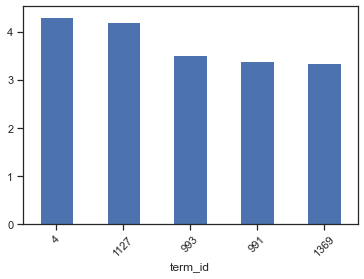

In [111]:
eig_pairs_0.exp_var.sort_values(ascending = False).head().plot.bar(rot = 45)

In [112]:
# pick top 10 components
comps_0 = eig_pairs_0.sort_values('exp_var', ascending = False).head(10).reset_index()
comps_0.index.name = 'comp_id'
comps_0.index = ["PC{}".format(i) for i in comps_0.index.tolist()]

In [113]:
comps_0

,term_id,eig_val,343,82,55,107,59,20,110,206,...,1187,1300,1325,1162,1369,991,993,1127,4,exp_var
PC0,4,0.955640,0.003009,0.012682,0.003948,-0.004066,-0.001016,-0.004909,-0.004875,0.027872,...,-0.006355,-0.004066,-0.004087,0.036458,0.031216,-0.004258,-0.008245,-0.007930,-0.000812,4.31
PC1,1127,0.933476,0.015624,0.012609,0.008142,0.004601,0.006073,0.013404,0.005895,-0.007850,...,0.007783,0.004601,-0.004986,-0.014934,-0.011170,0.012381,0.014856,0.019871,0.008293,4.21
PC2,993,0.779752,-0.016903,-0.051170,0.010654,0.000941,0.009263,0.045299,0.047480,0.047145,...,0.001303,0.000941,-0.006166,-0.041453,0.003908,0.028308,0.013371,0.001121,-0.000511,3.52
PC3,991,0.751933,0.019780,0.046809,0.013262,-0.009122,0.007663,-0.038476,-0.042681,-0.077587,...,-0.016544,-0.009122,0.004120,-0.008442,0.012938,-0.036199,-0.002557,0.016098,0.007159,3.39
PC4,1369,0.740097,0.043089,0.111304,-0.012701,0.003419,-0.022071,0.043098,-0.014377,0.036554,...,0.005364,0.003419,-0.003742,-0.037316,-0.019172,-0.015489,0.005394,0.040966,0.001108,3.34
PC5,1162,0.723157,0.010057,0.055053,0.029139,-0.002346,-0.009546,0.089684,0.091245,-0.006210,...,-0.008797,-0.002346,-0.021580,-0.006776,-0.015191,-0.020927,-0.002551,0.008526,-0.009792,3.26
PC6,1325,0.693964,0.030843,0.074192,-0.011300,-0.011215,-0.010566,-0.019887,-0.022396,0.013372,...,0.001329,-0.011215,0.015762,0.034578,0.005978,0.011150,-0.019570,-0.048099,-0.004917,3.13
PC7,1300,0.668254,-0.016027,-0.018715,0.052042,0.006556,0.012011,-0.067657,-0.111890,-0.028397,...,0.018953,0.006556,-0.009993,0.011828,0.007359,0.014256,0.043908,0.028460,-0.006402,3.01
PC8,1187,0.653484,-0.021773,-0.020401,0.033179,-0.037729,-0.026887,0.018775,0.006060,0.002312,...,-0.026946,-0.037729,-0.012115,0.071338,-0.022548,-0.034823,-0.023528,0.037276,-0.013646,2.95
PC9,1472,0.625283,0.014369,-0.009845,-0.013317,-0.020814,-0.008733,-0.053349,-0.058252,-0.009849,...,-0.014494,-0.020814,-0.023019,-0.041778,-0.021228,0.026828,-0.011238,-0.008444,0.005423,2.82


In [114]:
top_terms = [int(x) for x in eig_pairs_0.sort_values('exp_var', ascending = False).head(10).index]

In [115]:
# inspect terms
vocab[vocab.term_id.isin(top_terms)].term_str

155        rules
227     prepared
308      showing
329        tired
440     practice
511         seem
1003        wash
1016        tags
1083        term
1270       abide
Name: term_str, dtype: object

In [116]:
# show loadings 
loadings_0 = comps_0[term_idx_0].T
loadings_0.index.name = 'term_id'
loadings_0.head().style.background_gradient()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_id,,,,,,,,,,
343,0.003009,0.015624,-0.016903,0.019780,0.043089,0.010057,0.030843,-0.016027,-0.021773,0.014369
82,0.012682,0.012609,-0.051170,0.046809,0.111304,0.055053,0.074192,-0.018715,-0.020401,-0.009845
55,0.003948,0.008142,0.010654,0.013262,-0.012701,0.029139,-0.011300,0.052042,0.033179,-0.013317
107,-0.004066,0.004601,0.000941,-0.009122,0.003419,-0.002346,-0.011215,0.006556,-0.037729,-0.020814
59,-0.001016,0.006073,0.009263,0.007663,-0.022071,-0.009546,-0.010566,0.012011,-0.026887,-0.008733


In [117]:
loadings_0['term_str'] = loadings_0.apply(lambda x: vocab.loc[int(x.name)].term_str, 1)

In [118]:
l0_pos_0 = loadings_0.sort_values('PC0', ascending = True).head(10).term_str.str.cat(sep = ' ')
l0_neg_0 = loadings_0.sort_values('PC0', ascending = False).head(10).term_str.str.cat(sep = ' ')
l1_pos_0 = loadings_0.sort_values('PC1', ascending = True).head(10).term_str.str.cat(sep = ' ')
l1_neg_0 = loadings_0.sort_values('PC1', ascending = False).head(10).term_str.str.cat(sep = ' ')

In [119]:
print('Speakers PC0+', l0_pos_0)
print('Speakers PC0-', l0_neg_0)
print('Speakers PC1+', l1_pos_0)
print('Speakers PC1-', l1_neg_0)

Speakers PC0+ hey figured fine raise distractions real tiresome was parts door
Speakers PC0- complete rollercoaster included allowing our gum chelsea previously problems understanding
Speakers PC1+ hey party raise checking door people finishing was fine topics
Speakers PC1- perspective final called maybe playing meetings game ever un ru


In [120]:
dcm_0 = tfidf_0.dot(comps_0[term_idx_0].T).reset_index()
dcm_0

,speaker_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,202,-0.018862,0.234168,0.031653,0.171578,0.060551,-0.311760,-0.342279,0.158819,-0.273388,-0.184444
1,204,-0.124007,0.184018,-0.174615,0.036728,-0.022762,-0.354252,-0.221925,-0.006170,-0.352279,-0.356611
2,207,0.049096,0.265812,0.403632,-0.196261,-0.413383,-0.107228,0.332149,-0.577093,0.003388,0.993329
3,211,-0.052941,0.395175,0.037751,0.257916,0.311853,0.018174,-0.134492,0.305800,-0.107351,0.171677
4,212,-0.165703,0.517885,-4.801056,-2.750568,-0.623688,-0.132334,-1.018257,-0.339837,0.952920,-0.242276
5,214,-0.383106,0.054740,1.782846,-4.250872,1.286831,-0.001583,2.251966,1.562928,-0.242938,0.855294
6,215,-0.064016,0.274761,0.207511,0.080728,0.499691,-0.184104,-0.430356,0.193351,0.129556,-0.066505
7,217,0.557497,0.541440,-1.835393,1.619079,3.789292,1.831339,2.368399,-0.575304,-0.613267,-0.283184
8,219,-0.094574,0.298344,-0.124917,0.174220,0.021816,-0.020176,-0.029131,-0.151591,-0.068962,-0.406857
9,220,-0.353537,0.363617,1.164659,-0.055118,2.910412,-2.882274,-1.668763,-1.458568,2.475071,-0.136121


In [121]:
# visualize 
def vis_pcs(M, a, b, label = 'speaker_id', prefix = 'PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                     color = label, hover_name = 'speaker_id', marginal_x = 'box')
    fig.show()

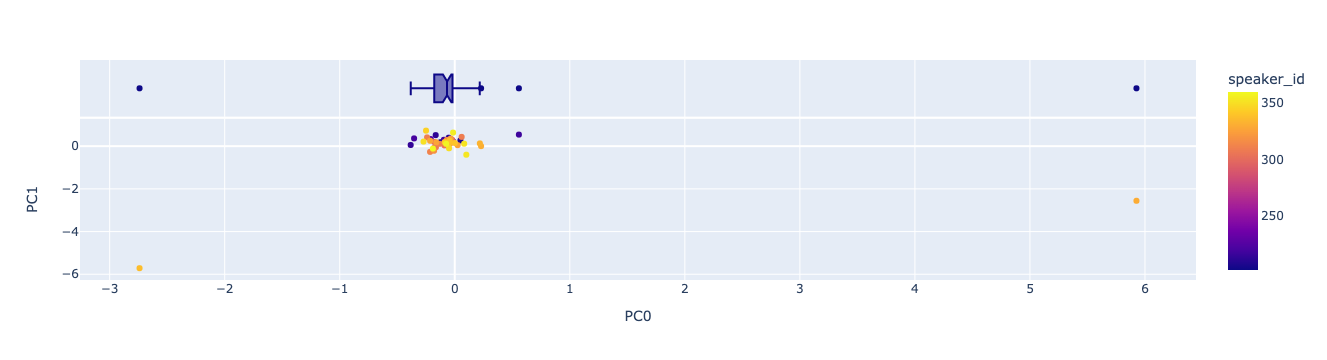

In [122]:
vis_pcs(dcm_0, 0, 1)

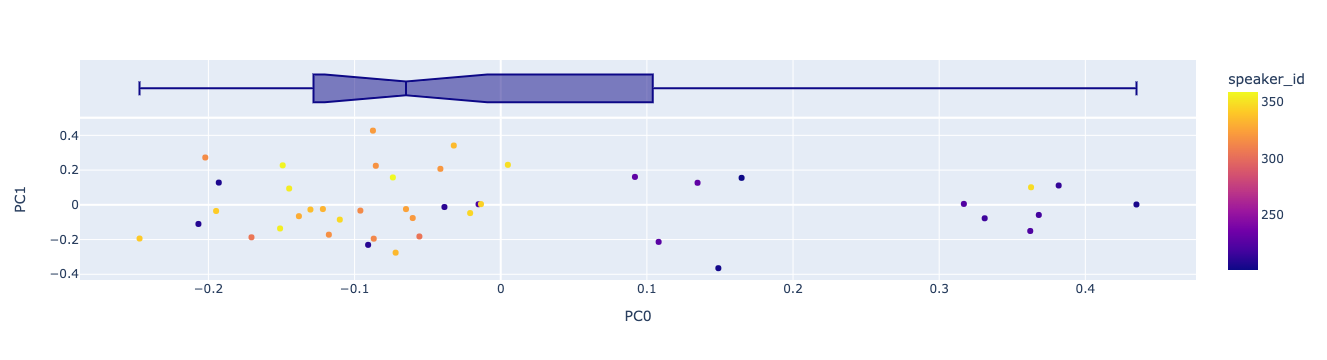

In [123]:
vis_pcs(dcm_1, 0, 1)

In [124]:
print('mindfull speakers PC0+', l0_pos_1)
print('mindfull speakers PC0-', l0_neg_1)
print('mindfull speakers PC1+', l1_pos_1)
print('mindfull speakers PC1-', l1_neg_1)
print('-------------------------------')
print('non-mindfull speakers PC0+', l0_pos_0)
print('non-mindfull speakers PC0-', l0_neg_0)
print('non-mindfull speakers PC1+', l1_pos_0)
print('non-mindfull speakers PC1-', l1_neg_0)

mindfull speakers PC0+ cross readings here keeping easier lockers someone classroom back direction
mindfull speakers PC0- came only break ha there jenna plot scale create restful
mindfull speakers PC1+ wherever throughout rhythm walls conversation update move lockers overbreak material
mindfull speakers PC1- rings rocket curious aside can yourselves un wiggle because change
-------------------------------
non-mindfull speakers PC0+ hey figured fine raise distractions real tiresome was parts door
non-mindfull speakers PC0- complete rollercoaster included allowing our gum chelsea previously problems understanding
non-mindfull speakers PC1+ hey party raise checking door people finishing was fine topics
non-mindfull speakers PC1- perspective final called maybe playing meetings game ever un ru


* in both the positive PCs for the non mindfulness group, there are words like mm, hey, quite, which shows more nervousness
* in the positive PCs for the mindfulness group, use more community words like throughout, conversation, someone 

#### all together

In [125]:
# see how things workout with all of them
bag = ['speaker_id']
bow = token.groupby(bag + ['term_id']).term_id.count().to_frame().rename(columns = {'term_id': 'n'})
bow['c'] = bow.n.astype('bool').astype('int')
bow.head()

n  c
speaker_id term_id      
201        8        6  1
           16       5  1
           21       1  1
           30       3  1
           43       4  1

In [126]:
dtcm = bow['n'].unstack().fillna(0).astype('int')
dtcm.head()

term_id,4,5,6,7,8,9,10,11,12,13,...,1543,1544,1545,1546,1547,1548,1549,1550,1551,1553
speaker_id,,,,,,,,,,,,,,,,,,,,,
201,0,0,0,0,6,0,0,0,0,0,...,0,0,17,0,5,1,1,0,0,0
202,0,0,0,0,2,0,0,0,0,0,...,1,0,15,0,4,0,0,0,0,0
203,0,0,0,0,4,0,0,0,0,0,...,0,0,19,0,9,0,0,0,0,0
204,0,0,0,0,6,0,0,0,0,0,...,0,0,29,0,9,0,0,0,0,0
205,0,0,0,0,5,0,0,0,0,0,...,2,0,26,0,6,0,0,0,0,0


In [127]:
# this will keep all the words since we have less than 4000 words in our vocab table
top_vocab = vocab['tfidf_sum'].nlargest(n=4000).rename_axis('term_id').reset_index()
top_vocab.head()

,term_id,tfidf_sum
0,647,0.234782
1,343,0.170105
2,82,0.130028
3,137,0.089034
4,55,0.079080


In [128]:
dtcm = top_vocab.merge(dtcm.T, how = 'inner', on = 'term_id').set_index('term_id').drop(columns = ['tfidf_sum'])

In [129]:
dtcm.head()

,201,202,203,204,205,206,207,208,209,210,...,351,352,353,354,355,356,357,358,359,360
term_id,,,,,,,,,,,,,,,,,,,,,
647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
343,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
82,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
137,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
55,0,0,0,0,0,1,0,2,0,0,...,0,0,0,0,0,0,0,0,0,2


In [130]:
# create tfidf matrix
tf = dtcm/dtcm.sum()
tf = tf.T

df = dtcm.T[dtcm.T > 0].count()

n = dtcm.T.shape[0]

idf = np.log10(n/df)

tfidf = tf*idf

tfidf.head()

term_id,647,343,82,137,55,42,107,59,20,98,...,1325,1162,1153,1369,991,993,1127,1006,1553,4
201,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
202,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.003304,0.003199,0.0,0.0,0.0
203,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000789,0.0,0.0,0.0
204,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.001735,0.0,0.001448,0.000000,0.0,0.0,0.0
205,0.0,0.0,0.0,0.0,0.0,0.0,0.006401,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.003907,0.000946,0.0,0.0,0.0


In [131]:
tfidf = tfidf.rename_axis('speaker_id')

In [132]:
# normalize doc vector lengths
tfidf = tfidf.apply(lambda x: x /np.sqrt(np.square(x).sum()), 1)

In [133]:
# center word vectors
tfidf = tfidf - tfidf.mean()

In [139]:
tfidf.to_csv('output files/tfidf_pca.csv')

In [134]:
# computer covariance matrix 
cov = tfidf.T.dot(tfidf)/(tfidf.shape[0]-1)

In [135]:
cov.head()

term_id,647,343,82,137,55,42,107,59,20,98,...,1325,1162,1153,1369,991,993,1127,1006,1553,4
term_id,,,,,,,,,,,,,,,,,,,,,
647,0.000155,-0.000007,-0.000002,-0.000003,-0.000024,-0.000002,-0.000005,-0.000004,0.000102,-0.000002,...,-0.000002,-0.000007,-0.000001,-0.000014,-0.000010,0.000138,0.000008,-0.000003,-0.000001,-0.000002
343,-0.000007,0.000613,0.000115,-0.000010,-0.000001,-0.000007,-0.000019,-0.000014,-0.000019,-0.000007,...,-0.000008,-0.000028,-0.000005,-0.000054,0.000026,-0.000008,-0.000024,-0.000013,-0.000005,0.000252
82,-0.000002,0.000115,0.000175,-0.000003,-0.000025,-0.000002,-0.000005,-0.000004,0.000049,-0.000002,...,-0.000002,-0.000008,-0.000001,-0.000015,-0.000011,-0.000025,0.000011,-0.000004,-0.000001,-0.000002
137,-0.000003,-0.000010,-0.000003,0.000326,-0.000034,-0.000003,-0.000007,-0.000005,0.000227,-0.000003,...,-0.000003,-0.000010,-0.000002,-0.000020,-0.000015,-0.000034,-0.000045,-0.000005,-0.000002,-0.000003
55,-0.000024,-0.000001,-0.000025,-0.000034,0.002058,0.000032,-0.000028,-0.000049,-0.000125,-0.000023,...,-0.000026,0.000191,-0.000017,-0.000020,-0.000038,-0.000031,0.000699,-0.000046,-0.000017,0.000039


In [136]:
cov.iloc[:5, :10].style.background_gradient()

term_id,647,343,82,137,55,42,107,59,20,98
term_id,,,,,,,,,,
647,0.000155,-0.000007,-0.000002,-0.000003,-0.000024,-0.000002,-0.000005,-0.000004,0.000102,-0.000002
343,-0.000007,0.000613,0.000115,-0.000010,-0.000001,-0.000007,-0.000019,-0.000014,-0.000019,-0.000007
82,-0.000002,0.000115,0.000175,-0.000003,-0.000025,-0.000002,-0.000005,-0.000004,0.000049,-0.000002
137,-0.000003,-0.000010,-0.000003,0.000326,-0.000034,-0.000003,-0.000007,-0.000005,0.000227,-0.000003
55,-0.000024,-0.000001,-0.000025,-0.000034,0.002058,0.000032,-0.000028,-0.000049,-0.000125,-0.000023


In [137]:
# decompose the matrix
from scipy.linalg import eigh
eig_vals, eig_vecs = eigh(cov)

In [140]:
# convert eigen data to dataframe
term_idx = cov.index
eig_vec = pd.DataFrame(eig_vecs, index = term_idx, columns = term_idx)

In [141]:
eig_val = pd.DataFrame(eig_vals, index = term_idx, columns = ['eig_val'])
eig_val.index.name = 'term_id'

In [142]:
eig_vec.head()

term_id,647,343,82,137,55,42,107,59,20,98,...,1325,1162,1153,1369,991,993,1127,1006,1553,4
term_id,,,,,,,,,,,,,,,,,,,,,
647,-0.001117,-0.039353,-0.008262,-0.013945,-0.014777,0.011779,0.008043,0.014582,-0.107081,0.064627,...,-0.001009,-0.015216,-0.000477,0.004091,0.008598,-0.009116,-0.009393,0.010143,-0.002254,0.020836
343,0.007301,-0.024500,0.133189,-0.120675,0.166552,0.025549,0.011937,0.041159,-0.083910,0.038802,...,0.010332,0.003087,-0.011697,0.008740,-0.006978,-0.021135,-0.000290,0.011987,-0.014863,-0.012661
82,0.005904,0.002680,0.081887,-0.117459,0.170469,-0.018676,0.041056,0.011359,-0.014288,-0.005260,...,0.013246,0.017959,0.013512,0.008276,-0.012638,-0.002985,-0.001792,0.010523,0.006683,0.005029
137,0.020270,0.054793,0.019257,-0.025063,0.024430,-0.057693,0.098173,0.225111,0.025205,0.034195,...,0.000665,-0.015848,0.011092,-0.004318,-0.027728,-0.017412,-0.001682,0.010626,-0.001659,-0.005036
55,0.010560,0.044359,0.023602,0.001540,0.029779,0.143117,0.077141,0.124355,0.021057,0.044281,...,-0.008715,0.114547,-0.072013,-0.004318,-0.041884,-0.018945,0.047814,0.051008,0.054968,-0.062834


In [143]:
eig_vec.iloc[:5, :10].style.background_gradient()

term_id,647,343,82,137,55,42,107,59,20,98
term_id,,,,,,,,,,
647,-0.001117,-0.039353,-0.008262,-0.013945,-0.014777,0.011779,0.008043,0.014582,-0.107081,0.064627
343,0.007301,-0.024500,0.133189,-0.120675,0.166552,0.025549,0.011937,0.041159,-0.083910,0.038802
82,0.005904,0.002680,0.081887,-0.117459,0.170469,-0.018676,0.041056,0.011359,-0.014288,-0.005260
137,0.020270,0.054793,0.019257,-0.025063,0.024430,-0.057693,0.098173,0.225111,0.025205,0.034195
55,0.010560,0.044359,0.023602,0.001540,0.029779,0.143117,0.077141,0.124355,0.021057,0.044281


In [144]:
eig_val.iloc[:5]

,eig_val
term_id,
647,-3.268653e-17
343,-2.017826e-17
82,-1.943393e-17
137,-1.803014e-17
55,-1.747031e-17


In [145]:
# select principal components
# combine eigenvalues and eigenvectors
eig_pairs = eig_val.join(eig_vec.T)

In [146]:
eig_pairs.head()

,eig_val,647,343,82,137,55,42,107,59,20,...,1325,1162,1153,1369,991,993,1127,1006,1553,4
term_id,,,,,,,,,,,,,,,,,,,,,
647,-3.268653e-17,-0.001117,0.007301,0.005904,0.020270,0.010560,0.003256,-0.008314,-0.001338,0.000416,...,0.003168,-0.002259,0.000706,0.000216,0.003895,-0.020281,0.006732,0.000801,0.001107,0.002513
343,-2.017826e-17,-0.039353,-0.024500,0.002680,0.054793,0.044359,-0.030331,-0.075099,0.002517,-0.072375,...,-0.002692,-0.020325,-0.001101,0.008975,0.013596,-0.088256,-0.000176,-0.024089,-0.001128,0.003828
82,-1.943393e-17,-0.008262,0.133189,0.081887,0.019257,0.023602,-0.008403,-0.002928,-0.031346,-0.012047,...,-0.001552,0.001216,-0.001260,-0.008324,-0.008528,-0.006843,-0.003979,-0.013086,-0.001558,-0.000561
137,-1.803014e-17,-0.013945,-0.120675,-0.117459,-0.025063,0.001540,-0.016135,-0.023078,-0.003258,-0.044785,...,-0.010184,0.013968,0.003152,0.011679,0.000213,-0.033232,0.011973,0.029334,0.003058,-0.005113
55,-1.747031e-17,-0.014777,0.166552,0.170469,0.024430,0.029779,-0.015024,-0.017969,-0.042322,0.053832,...,-0.002700,0.011495,-0.005390,0.005632,0.011977,-0.030788,0.012519,0.048844,-0.005889,-0.007395


In [147]:
# compute and show explained variance 
eig_pairs['exp_var'] = np.round((eig_pairs.eig_val / eig_pairs.eig_val.sum()) * 100, 2)

<AxesSubplot:xlabel='term_id'>

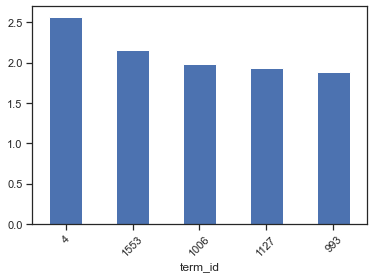

In [148]:
eig_pairs.exp_var.sort_values(ascending = False).head().plot.bar(rot = 45)

In [149]:
# pick top 10 components
comps = eig_pairs.sort_values('exp_var', ascending = False).head(10).reset_index()
comps.index.name = 'comp_id'
comps.index = ["PC{}".format(i) for i in comps.index.tolist()]

In [150]:
comps

,term_id,eig_val,647,343,82,137,55,42,107,59,...,1162,1153,1369,991,993,1127,1006,1553,4,exp_var
PC0,4,0.022975,0.020836,-0.012661,0.005029,-0.005036,-0.062834,-0.009960,0.041447,0.011948,...,-0.025520,-0.000240,-0.027581,-0.001285,0.030280,-0.018739,0.010067,-0.000240,-0.007303,2.57
PC1,1553,0.019254,-0.002254,-0.014863,0.006683,-0.001659,0.054968,-0.002278,-0.019620,-0.015459,...,0.009933,-0.002624,-0.032638,-0.042761,-0.104571,0.013877,0.015152,-0.002624,-0.005697,2.16
PC2,1006,0.017649,0.010143,0.011987,0.010523,0.010626,0.051008,0.005492,0.016084,-0.013138,...,-0.013712,-0.017851,-0.039245,-0.007168,0.038753,0.118876,0.009206,-0.017851,0.004222,1.98
PC3,1127,0.017190,-0.009393,-0.000290,-0.001792,-0.001682,0.047814,0.002343,-0.006971,0.008830,...,-0.026575,-0.019182,-0.007205,0.001930,0.001700,0.063880,-0.007857,-0.019182,-0.005586,1.93
PC4,993,0.016820,-0.009116,-0.021135,-0.002985,-0.017412,-0.018945,0.001010,-0.026102,0.018386,...,-0.014459,-0.004821,0.027804,-0.016659,-0.042053,-0.037252,-0.002616,-0.004821,-0.016888,1.88
PC5,991,0.016482,0.008598,-0.006978,-0.012638,-0.027728,-0.041884,-0.018353,0.029254,-0.031141,...,-0.001291,-0.002908,0.007360,-0.016348,-0.011953,0.045716,-0.013056,-0.002908,-0.007606,1.85
PC6,1369,0.016117,0.004091,0.008740,0.008276,-0.004318,-0.004318,-0.006776,0.023583,0.003631,...,0.006574,0.011000,-0.009005,-0.027506,-0.047940,-0.027429,-0.020559,0.011000,-0.002330,1.81
PC7,1153,0.015454,-0.000477,-0.011697,0.013512,0.011092,-0.072013,-0.005499,-0.003135,0.003297,...,0.015550,-0.000548,0.030741,-0.006275,-0.004268,-0.099966,0.029354,-0.000548,-0.004107,1.73
PC8,1162,0.015360,-0.015216,0.003087,0.017959,-0.015848,0.114547,-0.004085,0.009482,-0.010453,...,-0.001755,0.020860,0.030991,-0.024820,-0.053536,0.091398,-0.001778,0.020860,-0.007457,1.72
PC9,1325,0.014855,-0.001009,0.010332,0.013246,0.000665,-0.008715,0.020624,-0.016768,-0.031957,...,0.011775,0.002475,0.002513,-0.018068,-0.017635,0.012612,-0.032542,0.002475,0.000567,1.66


In [151]:
comps.to_csv('output files/comps_full.csv')

In [152]:
# inspect terms 
top_terms = [int(x) for x in eig_pairs.sort_values('exp_var', ascending = False).head(10).index]
vocab[vocab.term_id.isin(top_terms)].term_str

155        rules
227     prepared
329        tired
440     practice
511         seem
828      proceed
991      scratch
1083        term
1270       abide
1553        zone
Name: term_str, dtype: object

In [153]:
# show loadings 
loadings = comps[term_idx].T
loadings.index.name = 'term_id'
loadings.head().style.background_gradient()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
term_id,,,,,,,,,,
647,0.020836,-0.002254,0.010143,-0.009393,-0.009116,0.008598,0.004091,-0.000477,-0.015216,-0.001009
343,-0.012661,-0.014863,0.011987,-0.000290,-0.021135,-0.006978,0.008740,-0.011697,0.003087,0.010332
82,0.005029,0.006683,0.010523,-0.001792,-0.002985,-0.012638,0.008276,0.013512,0.017959,0.013246
137,-0.005036,-0.001659,0.010626,-0.001682,-0.017412,-0.027728,-0.004318,0.011092,-0.015848,0.000665
55,-0.062834,0.054968,0.051008,0.047814,-0.018945,-0.041884,-0.004318,-0.072013,0.114547,-0.008715


In [154]:
loadings['term_str'] = loadings.apply(lambda x: vocab.loc[int(x.name)].term_str, 1)

In [155]:
l0_pos = loadings.sort_values('PC0', ascending = True).head(10).term_str.str.cat(sep = ' ')
l0_neg = loadings.sort_values('PC0', ascending = False).head(10).term_str.str.cat(sep = ' ')
l1_pos = loadings.sort_values('PC1', ascending = True).head(10).term_str.str.cat(sep = ' ')
l1_neg = loadings.sort_values('PC1', ascending = False).head(10).term_str.str.cat(sep = ' ')

In [156]:
print('Speakers PC0+', l0_pos)
print('Speakers PC0-', l0_neg)
print('Speakers PC1+', l1_pos)
print('Speakers PC1-', l1_neg)

Speakers PC0+ readings cross kim here classroom can relax like let lockers
Speakers PC0- came only break ha there contact fits bag seated disrespected
Speakers PC1+ can afternoon material kayla what walls throughout maybe refresher aligns
Speakers PC1- rings yourselves tell aside feelings signals expected like life report


In [157]:
# project speakers onto new subspace
dcm = tfidf.dot(comps[term_idx].T).reset_index()
dcm

,speaker_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,201,0.144722,-0.196213,-0.160476,0.247053,0.097543,0.014056,0.047495,0.117965,0.002059,0.058244
1,202,0.087203,-0.277115,-0.103962,0.235998,-0.207724,0.179793,-0.027710,-0.050053,-0.059839,-0.005136
2,203,0.195573,-0.167078,-0.069430,-0.009960,0.231371,-0.372972,0.136455,-0.184744,-0.092181,-0.268363
3,204,0.377353,0.009198,-0.036521,-0.036528,0.117453,0.006341,-0.176084,0.060415,0.027285,0.202520
4,205,0.383314,-0.087961,0.061391,-0.054838,-0.125462,0.130464,0.107291,-0.008725,-0.015327,-0.105898
...,...,...,...,...,...,...,...,...,...,...,...
84,356,-0.149526,0.119337,0.151393,0.139415,0.088818,-0.164575,0.135760,0.023374,-0.064714,0.166950
85,357,-0.110130,0.082290,0.222272,-0.025423,0.005311,0.320178,-0.042647,-0.206763,-0.069538,0.001758
86,358,0.069394,0.168981,0.087586,0.015232,0.026381,0.033587,0.250759,0.476158,-0.070186,-0.153320
87,359,-0.062048,0.051699,0.005373,-0.275405,0.097413,0.289140,-0.021234,-0.016112,-0.162181,-0.011728


In [158]:
dcm = dcm.merge(survey)
dcm 

,speaker_id,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,mindfulness
0,201,0.144722,-0.196213,-0.160476,0.247053,0.097543,0.014056,0.047495,0.117965,0.002059,0.058244,1
1,202,0.087203,-0.277115,-0.103962,0.235998,-0.207724,0.179793,-0.027710,-0.050053,-0.059839,-0.005136,0
2,203,0.195573,-0.167078,-0.069430,-0.009960,0.231371,-0.372972,0.136455,-0.184744,-0.092181,-0.268363,1
3,204,0.377353,0.009198,-0.036521,-0.036528,0.117453,0.006341,-0.176084,0.060415,0.027285,0.202520,0
4,205,0.383314,-0.087961,0.061391,-0.054838,-0.125462,0.130464,0.107291,-0.008725,-0.015327,-0.105898,1
...,...,...,...,...,...,...,...,...,...,...,...,...
84,356,-0.149526,0.119337,0.151393,0.139415,0.088818,-0.164575,0.135760,0.023374,-0.064714,0.166950,0
85,357,-0.110130,0.082290,0.222272,-0.025423,0.005311,0.320178,-0.042647,-0.206763,-0.069538,0.001758,1
86,358,0.069394,0.168981,0.087586,0.015232,0.026381,0.033587,0.250759,0.476158,-0.070186,-0.153320,0
87,359,-0.062048,0.051699,0.005373,-0.275405,0.097413,0.289140,-0.021234,-0.016112,-0.162181,-0.011728,1


In [170]:
dcm.to_csv('output files/dcm_full.csv')

In [159]:
def vis_pcs(M, a, b, label = 'mindfulness', prefix = 'PC'):
    fig = px.scatter(M, prefix + str(a), prefix + str(b), 
                     color = label, hover_name = 'speaker_id', marginal_x = 'box')
    fig.show()

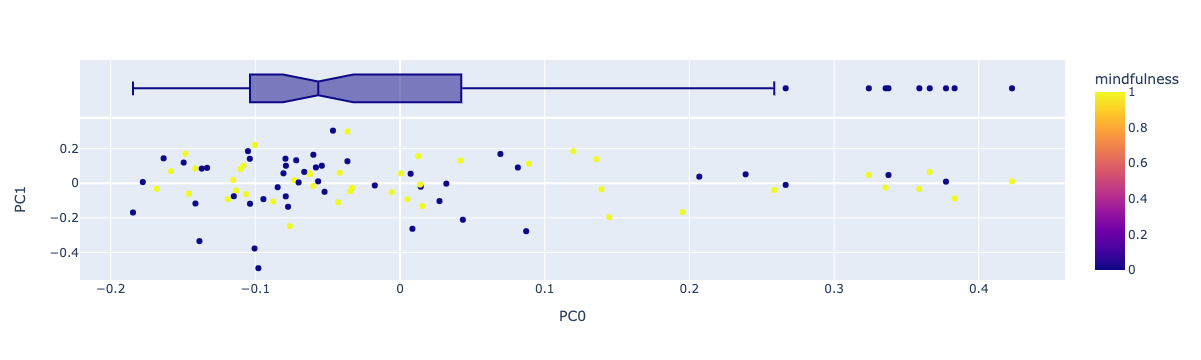

In [160]:
vis_pcs(dcm, 0, 1)

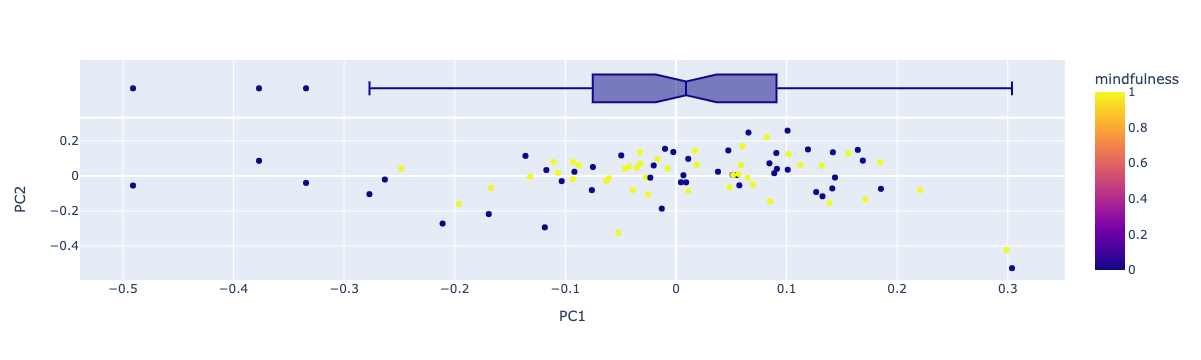

In [161]:
vis_pcs(dcm, 1, 2)

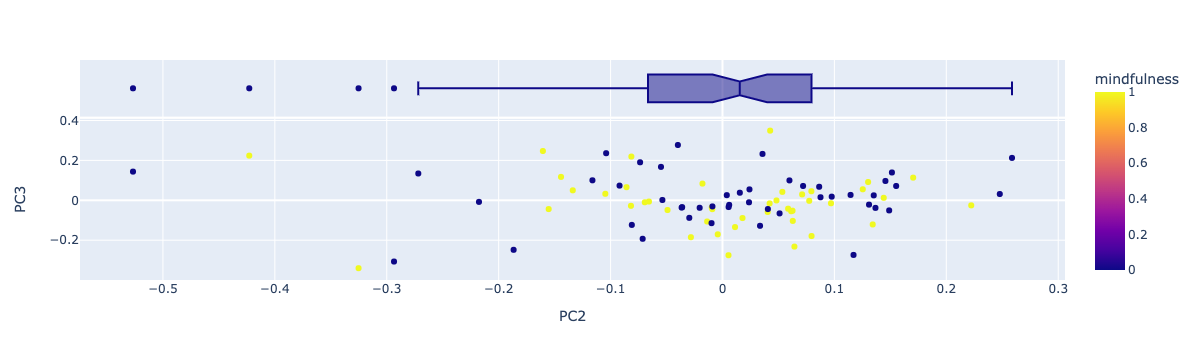

In [162]:
vis_pcs(dcm, 2, 3)

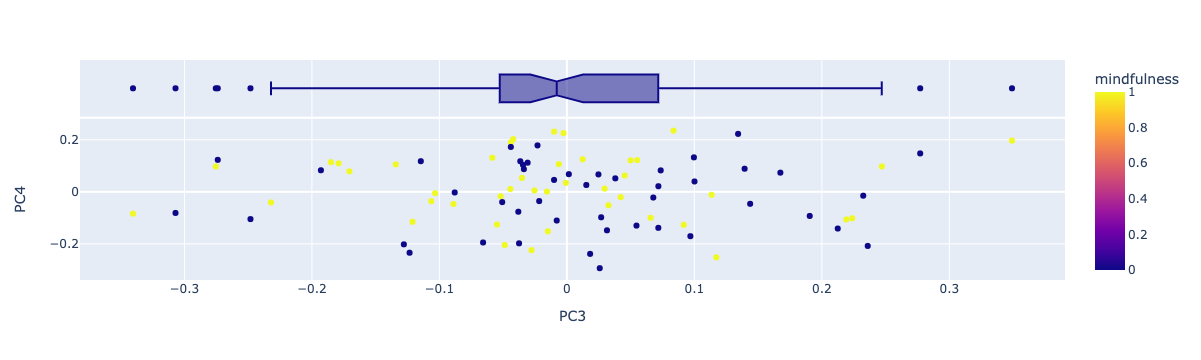

In [163]:
vis_pcs(dcm, 3, 4)

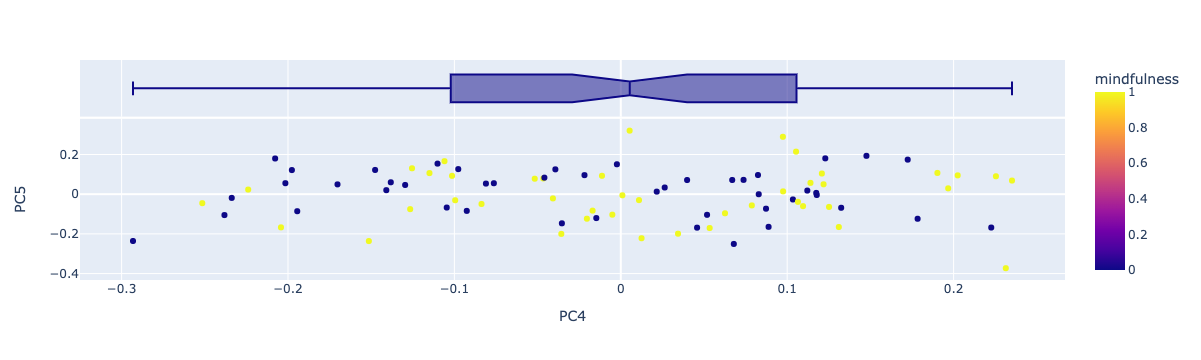

In [164]:
vis_pcs(dcm, 4, 5)

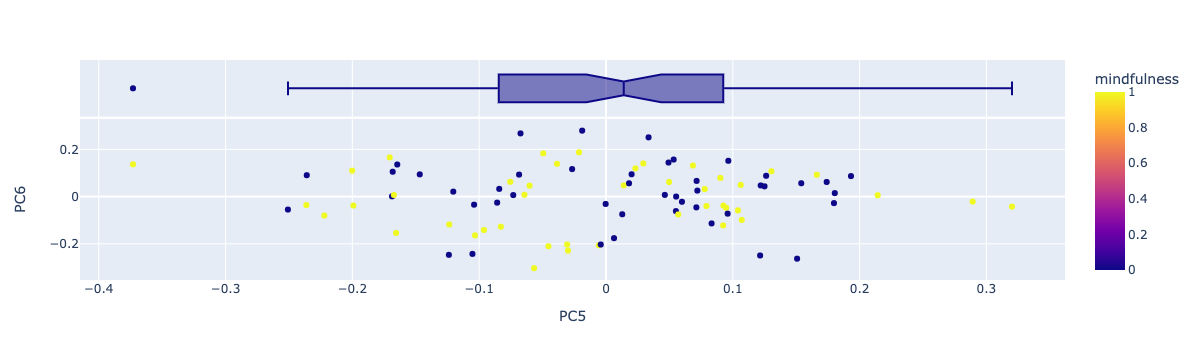

In [165]:
vis_pcs(dcm, 5, 6)

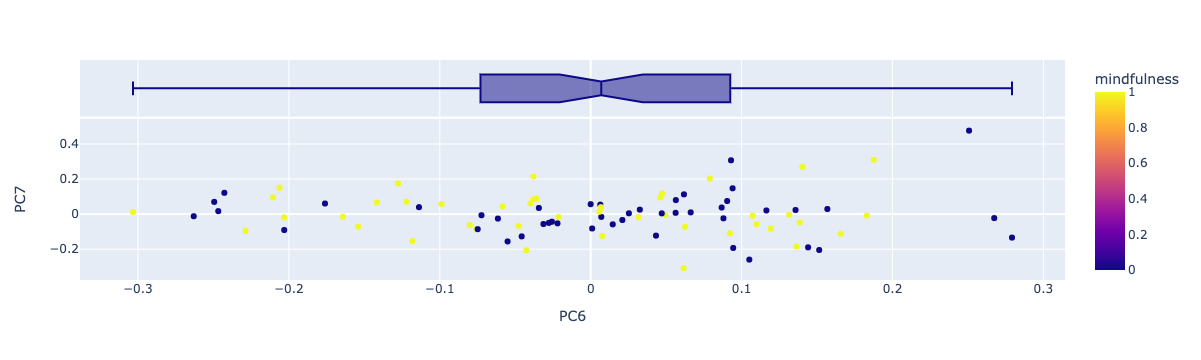

In [166]:
vis_pcs(dcm, 6, 7)

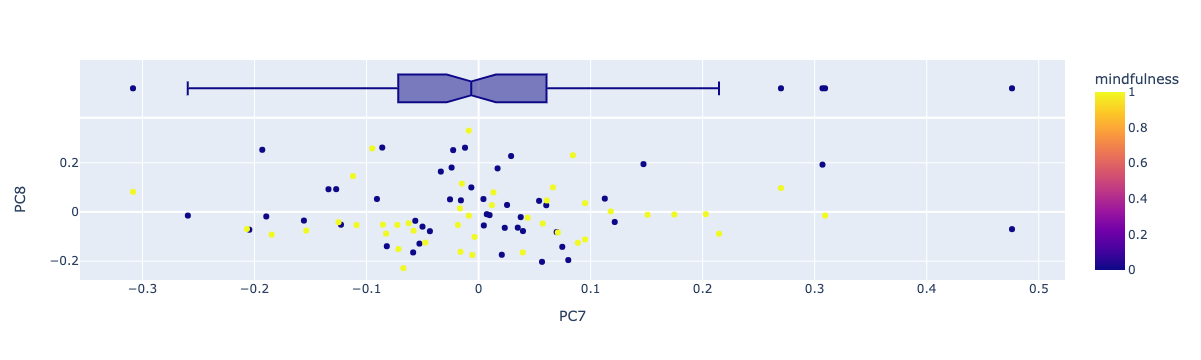

In [167]:
vis_pcs(dcm, 7, 8)

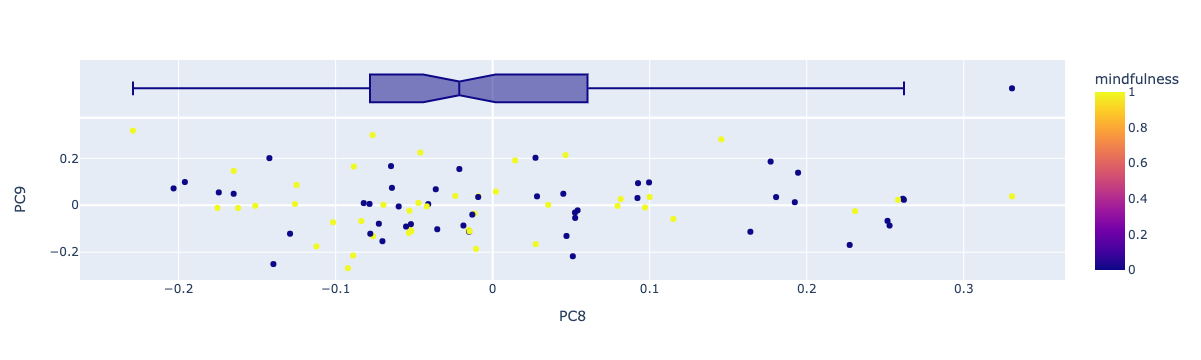

In [168]:
vis_pcs(dcm, 8, 9)

#### logistic regression with pca

In [171]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [172]:
dcm_log = dcm.set_index('speaker_id')
dcm_log

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,mindfulness
speaker_id,,,,,,,,,,,
201,0.144722,-0.196213,-0.160476,0.247053,0.097543,0.014056,0.047495,0.117965,0.002059,0.058244,1
202,0.087203,-0.277115,-0.103962,0.235998,-0.207724,0.179793,-0.027710,-0.050053,-0.059839,-0.005136,0
203,0.195573,-0.167078,-0.069430,-0.009960,0.231371,-0.372972,0.136455,-0.184744,-0.092181,-0.268363,1
204,0.377353,0.009198,-0.036521,-0.036528,0.117453,0.006341,-0.176084,0.060415,0.027285,0.202520,0
205,0.383314,-0.087961,0.061391,-0.054838,-0.125462,0.130464,0.107291,-0.008725,-0.015327,-0.105898,1
...,...,...,...,...,...,...,...,...,...,...,...
356,-0.149526,0.119337,0.151393,0.139415,0.088818,-0.164575,0.135760,0.023374,-0.064714,0.166950,0
357,-0.110130,0.082290,0.222272,-0.025423,0.005311,0.320178,-0.042647,-0.206763,-0.069538,0.001758,1
358,0.069394,0.168981,0.087586,0.015232,0.026381,0.033587,0.250759,0.476158,-0.070186,-0.153320,0


In [173]:
ho_lookup = pd.read_csv('holdout_samples_lookup.csv')

In [174]:
dcm_log = dcm_log.reset_index().merge(ho_lookup, left_on = 'speaker_id', right_on = 'studyid').drop(['studyid', 'mindfulness_y', '300s'], axis = 1).rename(columns = {'mindfulness_x': 'mindfulness'}).set_index('speaker_id')

In [175]:
dcm_log

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,mindfulness,holdout
speaker_id,,,,,,,,,,,,
201,0.144722,-0.196213,-0.160476,0.247053,0.097543,0.014056,0.047495,0.117965,0.002059,0.058244,1,0
202,0.087203,-0.277115,-0.103962,0.235998,-0.207724,0.179793,-0.027710,-0.050053,-0.059839,-0.005136,0,0
203,0.195573,-0.167078,-0.069430,-0.009960,0.231371,-0.372972,0.136455,-0.184744,-0.092181,-0.268363,1,1
204,0.377353,0.009198,-0.036521,-0.036528,0.117453,0.006341,-0.176084,0.060415,0.027285,0.202520,0,0
205,0.383314,-0.087961,0.061391,-0.054838,-0.125462,0.130464,0.107291,-0.008725,-0.015327,-0.105898,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
356,-0.149526,0.119337,0.151393,0.139415,0.088818,-0.164575,0.135760,0.023374,-0.064714,0.166950,0,0
357,-0.110130,0.082290,0.222272,-0.025423,0.005311,0.320178,-0.042647,-0.206763,-0.069538,0.001758,1,0
358,0.069394,0.168981,0.087586,0.015232,0.026381,0.033587,0.250759,0.476158,-0.070186,-0.153320,0,0


In [176]:
X = dcm_log[dcm_log.holdout == 0].drop(['mindfulness', 'holdout'], axis = 1)
y = dcm_log[dcm_log.holdout == 0].mindfulness
X_test = dcm_log[dcm_log.holdout == 1].drop(['mindfulness', 'holdout'], axis = 1)
y_test = dcm_log[dcm_log.holdout == 1].mindfulness

##### sklearn

In [177]:
log_reg = LogisticRegression(penalty = 'l2', solver = 'newton-cg', C = 10, random_state = 0).fit(X, y)

In [178]:
log_reg.coef_

array([[ 2.1735972 ,  1.25247626,  0.82102538, -1.22100528,  1.81639656,
        -0.05561494, -0.4615913 ,  0.92162331, -0.57137444,  0.86505377]])

In [179]:
log_reg.intercept_

array([-0.098134])

In [180]:
pred = log_reg.predict(X_test)

In [181]:
prediction = list(map(round, pred))

In [182]:
accuracy_score(y_test, prediction)

0.5

In [183]:
confusion_matrix(y_test, prediction)

array([[6, 3],
       [6, 3]])

In [184]:
print(classification_report(y_test, log_reg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         9
           1       0.50      0.33      0.40         9

    accuracy                           0.50        18
   macro avg       0.50      0.50      0.49        18
weighted avg       0.50      0.50      0.49        18



##### statsmodesl

In [185]:
import statsmodels.api as sm

In [186]:
log_reg_sm = sm.Logit(y, X).fit(method = 'newton')

Optimization terminated successfully.
         Current function value: 0.635699
         Iterations 5


In [187]:
print(log_reg_sm.summary())

                           Logit Regression Results                           
Dep. Variable:            mindfulness   No. Observations:                   71
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            9
Date:                Sun, 26 Mar 2023   Pseudo R-squ.:                 0.08170
Time:                        17:48:27   Log-Likelihood:                -45.135
converged:                       True   LL-Null:                       -49.150
Covariance Type:            nonrobust   LLR p-value:                    0.5310
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            2.7429      1.634      1.678      0.093      -0.460       5.946
PC1            1.6448      1.861      0.884      0.377      -2.002       5.291
PC2            1.0875      1.936      0.562      0.5

In [188]:
pred_sm = log_reg_sm.predict(X_test)

In [189]:
prediction = list(map(round, pred_sm))

In [190]:
print('actual values', list(y_test.values))
print('predicitions', prediction)

actual values [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
predicitions [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1]


In [191]:
cm_sm = confusion_matrix(y_test, prediction)
cm_sm

array([[5, 4],
       [4, 5]])

In [192]:
accuracy_score(y_test,prediction)

0.5555555555555556

In [193]:
log_reg_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            mindfulness   No. Observations:                   71
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            9
Date:                Sun, 26 Mar 2023   Pseudo R-squ.:                 0.08170
Time:                        17:48:31   Log-Likelihood:                -45.135
converged:                       True   LL-Null:                       -49.150
Covariance Type:            nonrobust   LLR p-value:                    0.5310
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC0            2.7429      1.634      1.678      0.093      -0.460       5.946
PC1            1.6448      1.861      0.884      0.377      -2.002       5.291
PC2            1.0875      1.936      0.562      0.574      -2.707       4.882
PC3           -1.6806      1.867     -0.900      0.368      -5.340       1.979
PC4            2.5357      1.924      1.318      0.187      -1.235       6.306
PC5           -0.2299      2.064     -0.111      0.911      -4.276       3.816
PC6           -0.6419      1.942     -0.331      0.741      -4.448       3.165
PC7            1.2805      1.930      0.663      0.507      -2.503       5.064
PC8           -0.8017      2.058     -0.390      0.697      -4.835       3.231
PC9            1.3319      2.166      0.615      0.539      -2.914       5.578
==============================================================================
"""

In [194]:
log_reg_sm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            Pseudo R-squared: 0.082   
Dependent Variable: mindfulness      AIC:              110.2692
Date:               2023-03-26 17:48 BIC:              132.8960
No. Observations:   71               Log-Likelihood:   -45.135 
Df Model:           9                LL-Null:          -49.150 
Df Residuals:       61               LLR p-value:      0.53104 
Converged:          1.0000           Scale:            1.0000  
No. Iterations:     5.0000                                     
-----------------------------------------------------------------
          Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
-----------------------------------------------------------------
PC0       2.7429     1.6342    1.6784   0.0933   -0.4601   5.9459
PC1       1.6448     1.8606    0.8840   0.3767   -2.0019   5.2915
PC2       1.0875     1.9362    0.5617   0.5743   -2.7074   4.8824
PC3      -1.6806     1.8670   -0.9002   0.3680   -5.3400   1.9787
PC4       2.5357     1.9237    1.3181   0.1875   -1.2347   6.3061
PC5      -0.2299     2.0642   -0.1114   0.9113   -4.2756   3.8159
PC6      -0.6419     1.9421   -0.3305   0.7410   -4.4485   3.1646
PC7       1.2805     1.9302    0.6634   0.5071   -2.5027   5.0637
PC8      -0.8017     2.0576   -0.3896   0.6968   -4.8345   3.2311
PC9       1.3319     2.1663    0.6148   0.5387   -2.9139   5.5778
===============================================================

"""

In [195]:
# find ratio of positive and negative words in each speaker and see if that has any prediction 
# look and see if there is a pretrained model for sentiment prediction 